In [29]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics

### Agent Definition

In [31]:
class BlackjackAgent:
  def __init__(
      self,
      learning_rate: float,
      initial_epsilon: float,
      epsilon_decay: float,
      final_epsilon: float,
      discount_factor: float = 0.95,
  ):
    # Initialize Q-table to zeros
    self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

    self.lr = learning_rate
    self.discount_factor = discount_factor
    self.epsilon = initial_epsilon
    self.epsilon_decay = epsilon_decay
    self.final_epsilon = final_epsilon

    self.training_error = []

  def get_action(self, obs: tuple[int, int, bool]) -> int:
    """
    Selects an action using epsilon-greedy for exploitation/exploration.
    """

    if np.random.random() >= self.epsilon:
      # Exploit
      return int(np.argmax(self.q_values[obs]))
    else:
      # Explore
      return env.action_space.sample()
    
  def update(
      self,
      obs: tuple[int, int, bool],
      action: int,
      reward: float,
      terminated: bool,
      next_obs: tuple[int, int, bool],
  ):
    future_q_value = (not terminated) * np.max(self.q_values[next_obs])
    temporal_difference = reward + self.discount_factor * future_q_value - self.q_values[obs][action]

    self.q_values[obs][action] = self.q_values[obs][action] + self.lr * temporal_difference
    self.training_error.append(temporal_difference)

  def decay_epsilon(self):
    self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

### Training

In [32]:
learning_rate = 0.001
n_episodes = 1_000_000
initial_epsilon = 1.0
epsilon_decay = initial_epsilon / (n_episodes / 2)
final_epsilon = 0.1

agent = BlackjackAgent(learning_rate, initial_epsilon, epsilon_decay, final_epsilon)

# Blackjack pays 3:2 (1.5 reward)
env = gym.make("Blackjack-v1", natural=True, sab=False)
env = RecordEpisodeStatistics(env, deque_size=n_episodes)

for episode in tqdm(range(n_episodes)):
  # Observation is (player_sum, dealer_card, usable_ace)
  obs, info = env.reset()
  done = False

  while not done:
    action = agent.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    agent.update(obs, action, reward, terminated, next_obs)

    done = terminated or truncated
    obs = next_obs

  agent.decay_epsilon()

100%|██████████| 1000000/1000000 [01:14<00:00, 13403.20it/s]


### Demonstration

In [33]:
num_hands = 100_000
num_blackjack = 0
num_wins = 0
num_pushes = 0
num_losses = 0

for hand in tqdm(range(num_hands)):
  obs, info = env.reset()
  done = False

  while not done:
    action = agent.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    done = terminated or truncated
    if done:
      if reward == 1.5:
        num_blackjack += 1
        num_wins += 1
      elif reward == 1:
        num_wins += 1
      elif reward == 0:
        num_pushes += 1
      elif reward == -1:
        num_losses +=1

    obs = next_obs

print(f'# of Hands Played: {num_hands}')
print(f'Win %: {num_wins / num_hands}')
print(f'Push %: {num_pushes / num_hands}')
print(f'Loss %: {num_losses / num_hands}')
print(f'Blackjack %: {num_blackjack / num_hands}')

100%|██████████| 100000/100000 [00:07<00:00, 13820.38it/s]

# of Hands Played: 100000
Win %: 0.41479
Push %: 0.08736
Loss %: 0.49785
Blackjack %: 0.04043


### Learning Stats

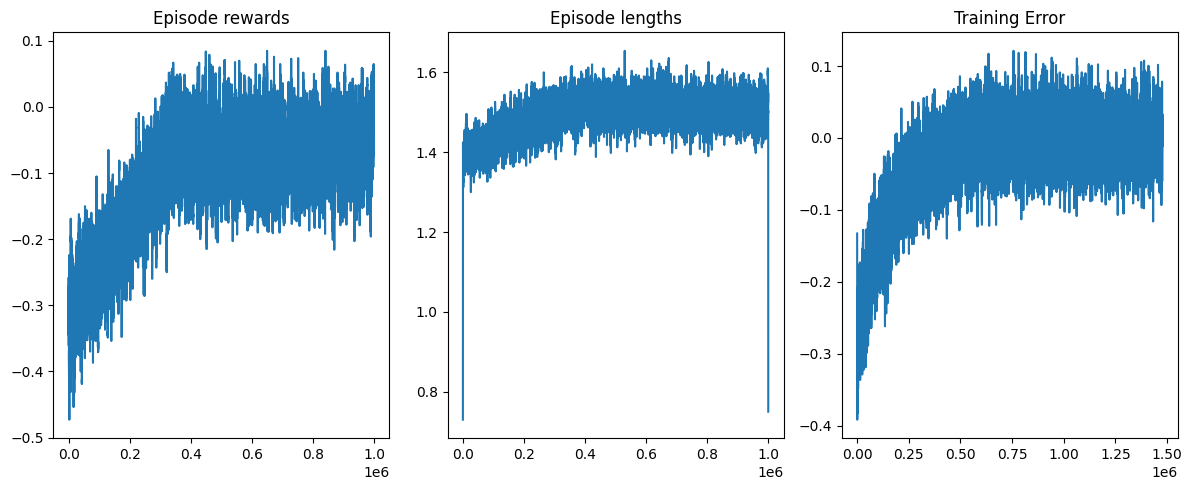

In [34]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

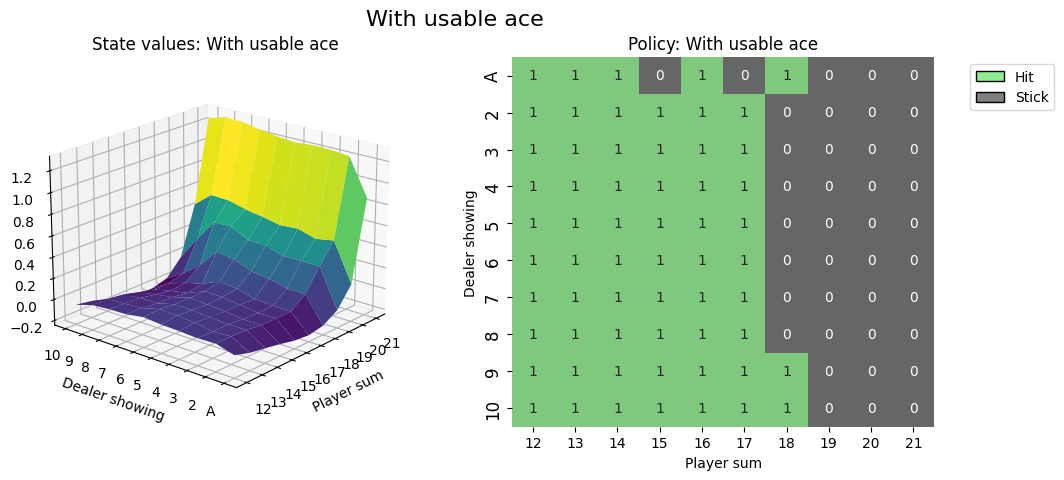

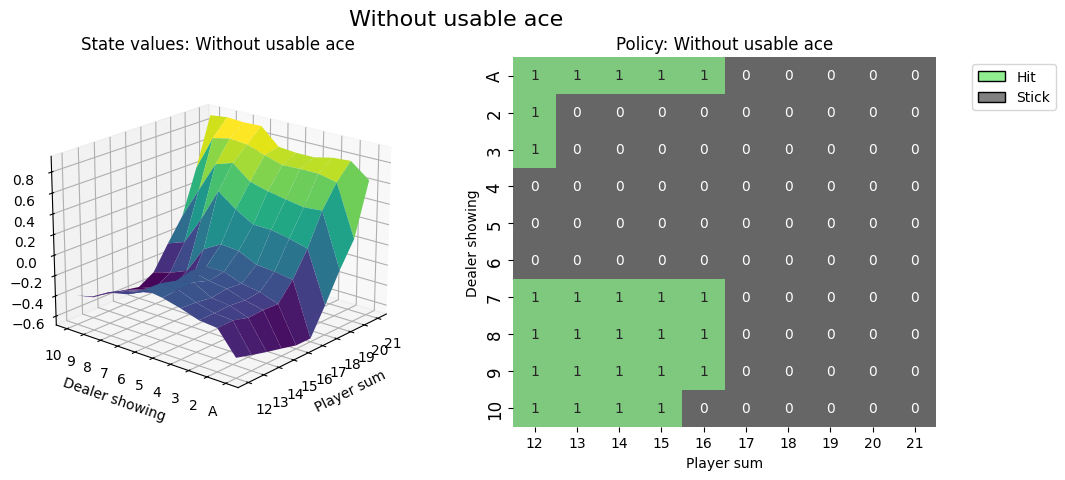

In [35]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [ ]:
env.close()